In [439]:

import pandas as pd
import numpy as np
import random
import pickle


In [441]:
df = pickle.load(open('dataframes/data_frame_RI10_p1.pcl','rb')) #берем дневную

In [442]:
date_l = list(df['<DATE>'])

In [443]:
df['hm']=round(df['<TIME>']/1000,0) #добавим еще одну фичу - час и десятки минут

In [444]:
df.head()

,<DATE>,<TIME>,<LAST>,vpin,oper_num,vpin_2,vpin_3,vpin_4,vpin_5,vpin_10,...,price_skew1_dif_2,price_skew_dif_3,price_skew1_dif_3,price_skew_dif_5,price_skew1_dif_5,price_skew_dif_10,price_skew1_dif_10,price_skew_dif_50,price_skew1_dif_50,hm
25854,20181022,110001,113500.0,0.428571,3,0.333333,0.200000,0.230769,0.125000,-0.147541,...,-1.809885,3.263675,1.607223,-0.610439,-1.599863,-23.623104,-1.096017,-2.449557,0.000000,110.0
25855,20181022,110001,113510.0,1.000000,1,0.500000,0.400000,0.272727,0.285714,-0.063830,...,0.000000,0.372159,-2.984796,2.840813,-1.600238,-3.623102,-1.095863,-2.447811,-1.214087,110.0
25856,20181022,110001,113500.0,-1.000000,1,0.000000,0.333333,0.272727,0.166667,-0.111111,...,0.000000,0.000000,3.415644,-3.140392,1.416742,-3.776410,0.453897,-4.771804,-1.213495,110.0
25857,20181022,110001,113510.0,1.000000,1,0.333333,0.500000,0.454545,0.384615,-0.028571,...,0.529044,16.042413,0.000000,-7.811829,-0.133275,0.000000,0.453094,-5.623772,-1.212904,110.0
25858,20181022,110001,113500.0,-1.000000,1,0.333333,0.000000,0.200000,0.333333,0.090909,...,0.000000,24.019170,3.415703,9.790602,3.016708,0.000000,1.265825,-5.620296,-0.552116,110.0


In [445]:

#выкиним все наны, которые остались от предыдущих преобзований
df.dropna(axis=0, how='any',inplace=True)
price_l = list(df['<LAST>'])
print(len(price_l))
#разметим данные поставим категорию, которая будет показывать 1 в случае если мы достигли +profit_loss за 200 следующих тиков
#либо -1 если мы достигли -profit_loss рублей
# и 0 если мы ничего не достигли

def set_sb_class():
    look_forward = 200 #на сколько тиков смотрим вперед. если не то ни другое то устанавливаем 0
    
    result_l = [0]*len(price_l)
    profit_loss  = 100 #тейк профит или стоп лосс
    for i in range(len(price_l)-look_forward):
        sb_category = 0
        try:
            start_price = price_l[i]
        except:
            print(i)
        for j in range(i+1,i+look_forward): #теперь пробежимся вперед от каждой цены и выставим 1 или -1 что быстрее = profit_losss
            if (price_l[j]-start_price)>=profit_loss:
                sb_category = 1 #/(j-i)
                break
            if (price_l[j]-start_price)<=-profit_loss:
                sb_category =-1 #/(j-i)
                break
        result_l[i]=sb_category
    return result_l

677317


In [446]:
df['target']=set_sb_class()

In [447]:
%matplotlib inline
import matplotlib.pyplot as plt

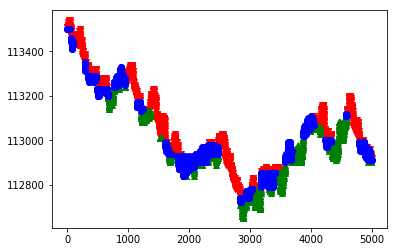

In [448]:
#визуализация резаметки
prom_target = df.target[0:5000]
prom_p = price_l[0:len(prom_target)]
red_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x<0]
green_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x>0]
zerro_v = [[j,prom_p[j]] for j,x in enumerate(prom_target) if x==0]
plt.plot(prom_p)
plt.plot(*zip(*red_v ), marker='v', color='r', ls='')
plt.plot(*zip(*green_v), marker='^', color='g', ls='')
plt.plot(*zip(*zerro_v), marker='o', color='b', ls='')
plt.show()

In [449]:
#удалим лишние колонки, котоыре будут сбивать обучение - дата, время и абсолютные значения цены и фильтров

In [450]:
columns_to_del = list(df.columns)[:3]
columns_to_del+=['kalman','kalman_slow']

In [451]:
columns_to_del

['<DATE>', '<TIME>', '<LAST>', 'kalman', 'kalman_slow']

In [452]:
for i in columns_to_del:
    del df[i]

In [453]:
#делим на train и test упрощенно - просто отрезаем хвост из test_size значений
def my_train_test_split(f,l,test_size):
    test_length = int(len(f)*test_size)
    return f[:-test_length],f[-test_length:],l[:-test_length],l[-test_length:]

In [454]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split

In [457]:
df = df.dropna(axis=0, how='any')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
features = df[df.columns[:-1]].values


#пастеризация - нормируем от -1 до 1 и округлим до 0.1 - это позволит модели искать взаимосвязь между
#показателями а не внутри одного - повышает качество на out_of_sample
scaler = StandardScaler()
scaler.fit(features)
features =scaler.transform(features)

features = np.around(features,decimals=1)




labels =df['target'].values

test_proc = 0.05 #тестовый размер 5% от train
train_features, test_features, train_labels, test_labels =my_train_test_split(features,labels,test_size = test_proc)

In [458]:
date_l[-len(test_features)],date_l[-1]

(20181213, 20181217)

In [459]:
#тестовая выборка - 4 дня

In [460]:
#посмотрим сколько у нас плюсов в категориях и минусов
len(df[df.target>0])/len(df[df.target<0])

1.0188273316178804

In [461]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

In [462]:
from sklearn.metrics import mean_squared_error
test_predicted_labels = []
def test(model):    
    tolerance = 0.5
    train_predicted_labels = model.predict(train_features)
    test_predicted_labels = model.predict(test_features)
    train_errors = mean_squared_error(train_labels,train_predicted_labels)
    test_errors = mean_squared_error(test_labels,test_predicted_labels)
    print('Train MSE',train_errors)
    print('Test MSE',test_errors)
    plt.plot(train_labels[:1000])
    plt.plot(train_predicted_labels[:1000])
    plt.show()
    plt.plot(test_labels[:1000])
    plt.plot(test_predicted_labels[:1000])
    plt.show()
    for j in range(10):
        print(test_labels[j],test_predicted_labels[j])
    count_p_error= 0
    count_m_error = 0
    #test = test_predicted_labels
    test = test_predicted_labels
    for j in range(len(test)):
        if abs(test[j])>tolerance:
            #print(test_predicted_labels[j],test_labels[j])
            if np.sign(test[j])==np.sign(test_labels[j]):
                count_p_error+=1
            else:
                count_m_error+=1
    if count_m_error == 0: count_m_error = 1
    print('PF:',count_p_error,count_m_error,count_p_error/count_m_error)
    
    big_num_errors_1 = []
    big_num_errors_2 = []

    
    for i,x in enumerate( test):
        if x>tolerance:
            big_num_errors_1.append(x)
            big_num_errors_2.append(test_labels[i])
    print('MSE+',mean_squared_error(big_num_errors_1,big_num_errors_2))
    print('PR+',sum([x for x in big_num_errors_2 if x>0])/sum([x for x in big_num_errors_2 if x<0]))
    big_num_errors_1 = []
    big_num_errors_2 = []
    print()
    for i,x in enumerate( test):
        if x<-tolerance:
            big_num_errors_1.append(x)
            big_num_errors_2.append(test_labels[i])
    print('MSE-',mean_squared_error(big_num_errors_1,big_num_errors_2))
    print('PR-',sum([x for x in big_num_errors_2 if x<0])/sum([x for x in big_num_errors_2 if x>0]))
    return test_predicted_labels
 

In [463]:
model = lgb.LGBMRegressor(n_estimators=1000,max_depth=20,num_leaves=100,learning_rate=0.1,
                         subsample_for_bin=20000)
model.fit(train_features,train_labels)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=20,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=1000, n_jobs=-1, num_leaves=100, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=20000, subsample_freq=0)

Train MSE 0.04794498332297969
Test MSE 0.6381799402355539


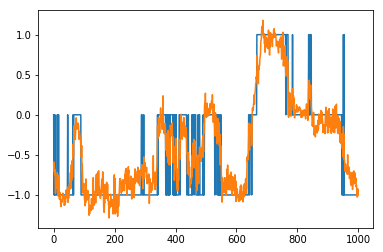

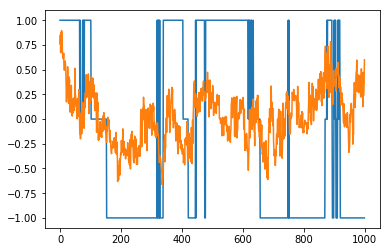

1 0.7617238937145657
1 0.8508226837989444
1 0.6714761606002195
1 0.8736065415560781
1 0.7055334255099691
1 0.8953685918920663
1 0.8734118014207489
1 0.7542034343097201
1 0.6633190253922404
1 0.6430455061127162
PF: 1118 2358 0.4741306191687871
MSE+ 0.6604057401380686
PR+ -2.0110192837465566

MSE- 0.744314386870866
PR- -1.7168141592920354


In [467]:
test_predicted_labels = test(model)

In [468]:
columns_model = list(df.columns)
best_f_l = []
for i,x in enumerate(model.feature_importances_):
    best_f_l.append([columns_model[i],x])
best_f_l.sort(key=lambda x: x[1],reverse = True)
best_f_l[:20] #лучшие 20 фич

[['ang_lr_5000', 2826],
 ['vpin_5000', 2644],
 ['hm', 2361],
 ['rsi_1000', 2334],
 ['price_skew1_50', 2331],
 ['mean_vol_1000', 2259],
 ['min_max_1000_dist', 2119],
 ['vpin_1000', 2055],
 ['price_std1_50', 2039],
 ['ang_lr_1000', 1974],
 ['price_skew_50', 1970],
 ['price_skew1_10', 1927],
 ['price_skew1_2', 1893],
 ['price_std_50', 1821],
 ['price_skew1_3', 1795],
 ['price_skew1_5', 1758],
 ['min_1000_dist', 1734],
 ['max_1000_dist', 1730],
 ['mean_vol_500', 1726],
 ['ang_lr_500', 1718]]

In [469]:
import numpy as np
import pandas as pd
import simdkalman
import talib
import random
from simdkalman.primitives import predict, update
#класс функций для работы с list ордеров и сделками. у каждого ордера может быть два состояния исполнен или ожидает. если мы отменяем то выкидывваем
#здесь хранием откртые и исполненные ордера и по ним всегда можно подсчитать вармаржу. отмененные выкидываем
class Executor:
    def __init__(self):
        self.quantity = 0 #текущее количество на руках
        self.cost = 0.0 #себестоимость позиции
        self.market_value = 0.0 #рыночная стоимость 
        self.r_pnl = 0.0 #накопленная прибыль (только закрытые позиции)
        self.average_price = 0.0 #средняя цена за штуку на руках
        self.open_orders = []#заявки (снятые выкидываем)
        self.my_trades = []#сделки
        self.REAL_TRADE = False #если True то сделки и заявки подает транзак по callback
        self.on_price_prob = 1.0 #вероятность исполнения тика
        self.total_profit = 0.0 #общая прибыль с учетом незакрытых сделок
        self.equity = [] #история эквити
        self.position = [] #история позиции
        self.plt_buy = [] #для графика сделок
        self.plt_sell = [] #для графика сделок
        self.plt_price = [] #для графика сделок
        self.total_volume = 0 #общее количество проторгованных лотов
        self.price_of_last_deal = 0 #цена последней сделки
        self.stop_losses = [] #таблица стоплоссов - при достижении цены или окончания времени - выставляется заявка
        self.out_order_delta = 0.0 #снимаем заявки, которые ушли от текущей цены
        self.deals_for_pf = [] #результаты сделок
        self.max_position = 1000 #максимальная поза. если идет превышение, то игнорируем заявки

                
    def fill(self, pos_change, exec_price):
        self.my_trades.append([exec_price,pos_change])
        n_pos =self.quantity+pos_change
        
        direction = np.sign(pos_change)
        prev_direction = np.sign(self.quantity)
        qty_closing = min(abs(self.quantity), abs(pos_change)) * direction if prev_direction != direction else 0
        
        qty_opening = pos_change if prev_direction == direction else pos_change - qty_closing
        

        new_cost = self.cost + qty_opening * exec_price
        
        if self.quantity != 0:
            new_cost += qty_closing * self.cost / self.quantity
            profit = qty_closing * (self.cost / self.quantity - exec_price)
            self.r_pnl += profit
            self.deals_for_pf.append(profit)
            
        self.quantity = n_pos
        self.cost = new_cost
        
        if self.quantity != 0:
            self.average_price = self.cost / self.quantity
        else: 
            self.average_price = 0
            
        if pos_change>0:
            self.plt_buy.append([len(self.plt_price)+1,exec_price])
        else:
            self.plt_sell.append([len(self.plt_price)+1,exec_price])
            
        self.total_volume+=abs(pos_change)
        self.price_of_last_deal = exec_price

    def u_pnl(self, price):
        self.market_value = self.quantity * price
        return self.market_value - self.cost
        
        

    def add_order(self,price,qnt,sl_price = 0,sl_time = 10000): #добавить ордер. минус - продажа
        #tp это знак ордера продажа или покупка
        
        tp=np.sign(qnt)
        
        if (tp<0 and self.quantity<=-self.max_position) or (tp>0 and self.quantity>=self.max_position):
            #мы превышаем максимальную позу,пропускаем
            pass
        else:
            if qnt!=0:
                if self.REAL_TRADE:

                    if tp>0:
                        print(trans_quik('B',price,abs(qnt)))
                    else:
                        print(trans_quik('S',price,abs(qnt)))
                else:
                    if self.on_price_prob<1.0:
                        self.open_orders.append([price,qnt,tp,0])
                    else:
                        self.fill(qnt,price) 
            if sl_price>0:
                self.stop_losses.append([sl_price,-qnt,sl_time])

    def cancel_orders(self,tp): #отменить все ордера по направлению. например -1 снять все ордера на продажу
        for x in reversed(self.open_orders):
        
            
            if x[2] == tp and x[3]<1:
                if self.REAL_TRADE and x[5]!=None:
                    trans_quik('C',0,0,x[4])
                else:
                    self.open_orders.remove(x)
    def cancel_order(self,order):
        if not self.REAL_TRADE:
            self.open_orders.remove(order)
        else:
            trans_quik('C',0,0,order[4])
    def cancel_out_orders(self,price,delta):#отменить все ордера с делтой цены больше чем
        
        for x in reversed(self.open_orders):
        
            
            if x[3]<1 and abs(x[0]-price)>delta:
                if self.REAL_TRADE and x[5]!=None:
                    trans_quik('C',0,0,x[4])
                else:
                    self.open_orders.remove(x)
            
    def order_on_price(self,price):
        if self.on_price_prob<1.0:
            for x in self.open_orders:
                if x[3]<1 and x[0]==price:
                    return True
        return False
    
    def update(self,price,update_stat=True):#запускается каждый раз при измении цены. проверяет пересекла тек цена цену ордера или нет
        for x in reversed(self.stop_losses):
            x[2]-=1
            removed = False
            if x[0]==price:
                    
                self.add_order(price,x[1])
                self.stop_losses.remove(x)
                removed = True
                    
            if x[2]<=0 and not removed:
                self.add_order(price,x[1])
                self.stop_losses.remove(x)
        
        if not self.REAL_TRADE:
            
            
            for x in reversed(self.open_orders):
        
            
                if x[3]>0: #выкинем все исполненные ордера
                    self.open_orders.remove(x)
                    
            for x in self.open_orders:
                if x[3]<1: #только открытые ордера
                    if x[2]<0 and price>x[0]: #продажа и цена ушла выше - исполнен
                        x[3]= 1
                        self.fill(x[1],x[0])
                    elif x[2]>0 and price<x[0]:#покупка и цена ушла ниже - исполнен
                        x[3]=1
                        self.fill(x[1],x[0])
                    if self.on_price_prob>0.0:
                        if price==x[0] and random.random()<self.on_price_prob:
                            x[3] = 1
                            self.fill(x[1],x[0])
        else:
            pass
            #for x in self.open_orders:
            #здесь надо поставить выкидывание ордеров неправильных

        if update_stat:
            self.equity.append(self.r_pnl+self.u_pnl(price))
            self.position.append(self.quantity)
            self.plt_price.append(price)
            self.total_profit = self.r_pnl+self.u_pnl(price)
        if self.out_order_delta>0:
            self.cancel_out_orders(price,self.out_order_delta)
                
    def var_margin(self,price):#считаем текущую вар маржу
        margin = 0
        for x in self.open_orders:
            margin+=(price-x[0])*x[1]*x[3] #(тек цена минус цена оредра ) умножить на колво и на признак исполнения)
        return margin
    def get_position(self):#возвращает число лотов на руках    
        return sum([x[1] for x in self.open_orders if x[3]==1])

    def get_position_price(self,): #считает среднюю цену лотов на руках
        return sum([sum([x[1]*x[0] for x in self.open_orders if x[3]==1])])/sum([x[1] for x in self.open_orders if x[3]==1])
    
    def get_ppd(self):
        if self.total_volume>0:
            return (self.total_profit/self.total_volume)*2
        else:
            return 0.0
    def get_profit_factor(self):
        plus_deals = sum([x for x in self.deals_for_pf if x>0])
        minus_deals = sum([x for x in self.deals_for_pf if x<=0])
        if minus_deals==0:
            minus_deals = 1
        return plus_deals/minus_deals
    
        
    def plot_stat_3(self):
        
        plt.plot(self.plt_price)
        plt.plot(*zip(*self.plt_sell), marker='v', color='r', ls='')
        plt.plot(*zip(*self.plt_buy), marker='^', color='g', ls='')
        plt.show()
        plt.plot(self.equity, color = 'b')
        plt.show()
        plt.plot(self.position)
        plt.show()
    
    def plot_deals(self,last = 0): #тут недоделано про last
        if last == 0:
            last_for_sell = 0
            last_for_buy = 0
        
            
        plt.plot(exe.plt_price[-last:])
        plt.plot(*zip(*exe.plt_sell[-last_for_sell:]), marker='v', color='r', ls='')
        plt.plot(*zip(*exe.plt_buy[-last_for_buy:]), marker='^', color='g', ls='')
        plt.show()
    

    
    ### добавить функции по работе с ордерами из api hft_battle
    


In [478]:
def back_test(tolerance,take_profit,stop_loss_time,start=0,end = 0, show_graphs = True):
    exe = Executor()
    exe.on_price_prob = 1 #вероятность исполнения по тику 100%
    exe.out_order_delta = 30 #для меньшей вероятности они образуются неисполненные ордера. снимаем их если цена ушла больше чем
    exe.max_position = 100 #ограничение максимальной позы. если больше, то просто игнорируеми ордера
    if end==0:
        end = len(test_predicted_labels)
    test = test_predicted_labels[start:end]
    
    l= len(test)
    
    test_data = df[-l:]
    test_price = price_l[-l:]

    for t in range(l):
        price = test_price[t]
        betta = test[t]
        if betta>tolerance and not exe.order_on_price(price):
            exe.add_order(price,1,sl_price = price+take_profit,sl_time = stop_loss_time)
        elif betta<-tolerance and not exe.order_on_price(price):
            exe.add_order(price,-1,sl_price=price-take_profit,sl_time = stop_loss_time)

        exe.update(price)
    if show_graphs:
        exe.plot_stat_3()

    return round(exe.r_pnl,2),round(exe.get_ppd(),3),abs(round(exe.get_profit_factor(),3))

In [477]:
results = []
#попробуем перебарть 
for i in range(100):
    if i%10==0:
        print('|',end='')
        
    a,b,c = random.randint(1,10)/10,random.randint(1,20)*10,random.randint(1,10)*10
    r = back_test(tolerance=a,take_profit=b,stop_loss_time=c,show_graphs = False)
    results.append((a,b,c)+r)

||||||||||

In [504]:
results.sort(key=lambda x: x[4],reverse = True)
# 3 - сортировка по общей сумме
# 4 - по средней прибыли на сделку
# 5 - по PF

In [513]:
results[0:20]


[(1.0, 60, 100, 900.0, 36.0, 19.0),
 (0.9, 190, 100, 3130.0, 33.656, 8.62),
 (0.9, 160, 100, 2920.0, 31.398, 8.109),
 (1.0, 90, 100, 780.0, 31.2, 14.565),
 (1.0, 90, 100, 780.0, 31.2, 14.565),
 (1.0, 30, 40, 750.0, 30.0, 750.0),
 (0.9, 190, 80, 2710.0, 29.14, 5.659),
 (1.0, 50, 80, 710.0, 28.4, 12.181),
 (0.8, 190, 100, 7580.0, 28.074, 6.052),
 (0.8, 70, 100, 7120.0, 26.37, 5.854),
 (0.8, 80, 100, 7020.0, 26.0, 5.782),
 (0.8, 190, 90, 6970.0, 25.815, 5.223),
 (0.8, 50, 100, 6750.0, 25.0, 6.079),
 (1.0, 150, 80, 620.0, 24.8, 6.277),
 (0.8, 160, 90, 6640.0, 24.593, 5.023),
 (0.8, 180, 80, 6340.0, 23.481, 4.565),
 (0.9, 190, 30, 2090.0, 22.473, 6.502),
 (0.8, 140, 80, 5970.0, 22.111, 4.357),
 (0.8, 90, 80, 5940.0, 22.0, 4.352),
 (0.9, 130, 50, 2020.0, 21.72, 5.489)]

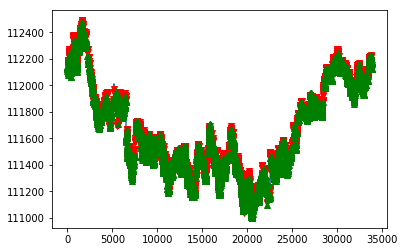

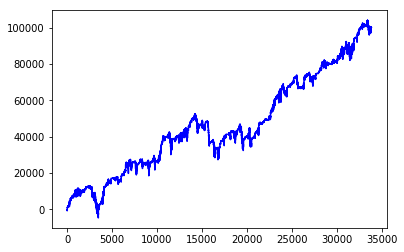

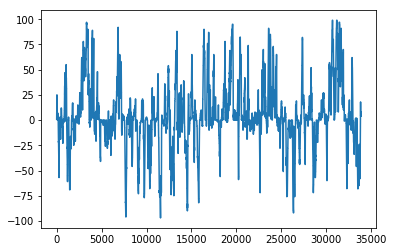

(100058.61, 8.863, 1.687)

In [508]:
back_test(tolerance=0.3,take_profit=50,stop_loss_time=100)

In [511]:
#здесь другой алгоритм - при превышлении tolerance покупаем, 
#при -tolerance продаем вселонги  что набрали и начинаем набирать позу в другую сторону
def back_test_2(tolerance,take_profit=0,stop_loss_time=0,last = 0, show_graphs = True):
    exe = Executor()
    exe.on_price_prob = 1
    exe.out_order_delta = 20
    exe.max_position = 100
    test = test_predicted_labels[-last:]
    
    l= len(test)
    print(l)
    test_data = df[-l:]
    test_price = price_l[-l:]

    for t in range(l):
        price = test_price[t]
        betta = test[t]
        if betta>tolerance and not exe.order_on_price(price):
            if exe.quantity>=0:
                exe.add_order(price,1)
            else:
                exe.add_order(price,-exe.quantity)
        elif betta<-tolerance and not exe.order_on_price(price):
            if exe.quantity<=0:
                
                exe.add_order(price,-1)
            else:
                exe.add_order(price,-exe.quantity)
        exe.update(price)
    if show_graphs:
        exe.plot_stat_3()
    return round(exe.r_pnl,2),round(exe.get_ppd(),3),abs(round(exe.get_profit_factor(),3))

33865


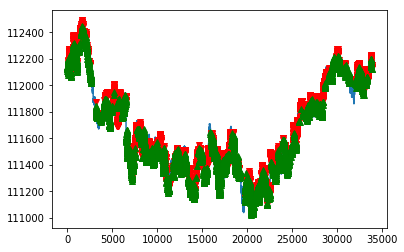

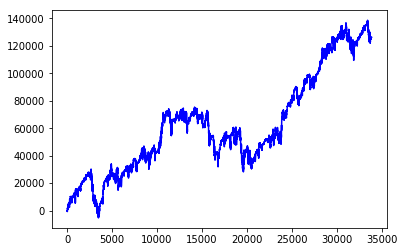

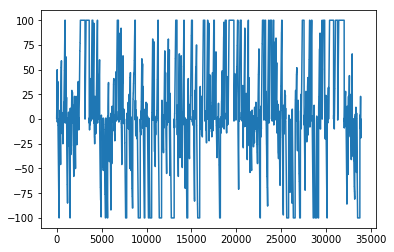

(126360.0, 8.589, 1.566)

In [512]:
back_test_2(0.15,10,last=0)

In [189]:
exe.stop_losses

[[112170.0, -1, 13],
 [112170.0, -1, 20],
 [112170.0, -1, 22],
 [112170.0, -1, 24],
 [112170.0, -1, 26],
 [112170.0, -1, 28],
 [112160.0, -1, 33],
 [112160.0, -1, 35],
 [112160.0, -1, 37]]

In [322]:
exe.deals

AttributeError: 'Executor' object has no attribute 'deals'